## Implementation Tutorial for Neural Radiosity [Hadadan et al. 2021]
In this tutorial, we will implement a novel global illumination technique called Neural Radiosity using python, PyTorch, and Mitsuba 3, which was introduced at SIGGRAPH 2021. Mitsuba 3 is a new rendering library that has received considerable attention in recent research, but open source projects using it are still not very active. Therefore, the primary goal of this tutorial is to introduce the various features available in Mitsuba 3 to rendering novices while implementing a novel renderer. Enjoy!

Please leave any inquiries in the GitHub Issues section. Also, please note that I am not the author of Neural Radiosity nor Mitsuba 3.

### Install dependencies
Please refer to the README.md file in the main directory to install Mitsuba 3 and PyTorch dependencies. Once you have done that, run the code block provided below.

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")

import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from mitsuba.python.ad.integrators.common import ADIntegrator, mis_weight
from tqdm import tqdm

### Setup a scene
For this tutorial, let's load the default Cornell Box scene from Mitsuba 3 and render it.

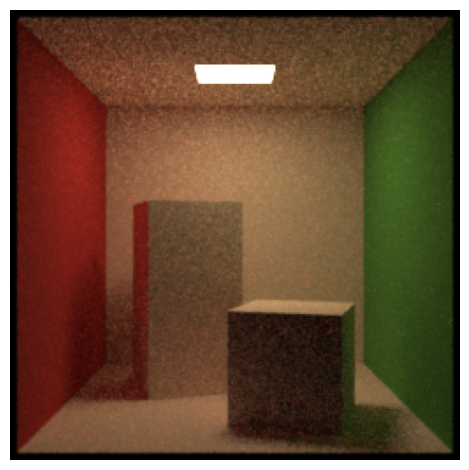

In [2]:
# Easy scene
scene_dict = mi.cornell_box()
scene = mi.load_dict(scene_dict)
original_image = mi.render(scene, spp=16)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
ax.imshow(np.clip(original_image ** (1.0 / 2.2), 0, 1))

The Cornell Box scene that we rendered earlier looks too bland. Shall we remove boxes and add a glass ball? You can follow the code below to do so.

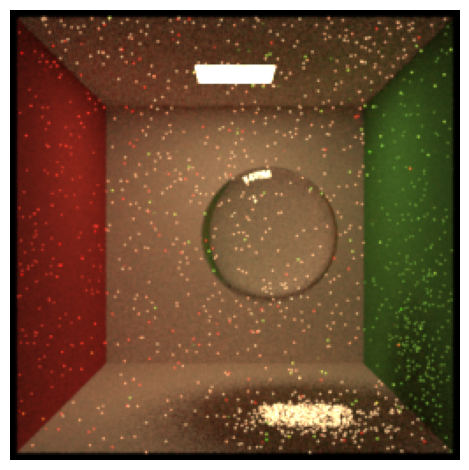

In [3]:
# Harder scene
# To change the order so that the declaration of glass BSDF occurs before the reference of it, we need to use the `pop` function.
scene_dict = mi.cornell_box()
scene_dict.pop("small-box")
scene_dict.pop("large-box")
scene_dict["glass"] = {"type": "dielectric"}
scene_dict["ball"] = {
    "type": "sphere",
    "to_world": mi.ScalarTransform4f.scale([0.4, 0.4, 0.4]).translate([0.5, 0, 0.5]),
    "bsdf": {"type": "ref", "id": "glass"}
}

scene = mi.load_dict(scene_dict)
original_image = mi.render(scene, spp=16)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
ax.imshow(np.clip(original_image ** (1.0 / 2.2), 0, 1))

Look good!

### Prerequesite for Uniform Sampling on Surfaces: Discarding Delta Surfaces
To implement Neural Radiosity, the first step is to uniformly sample positions on the mesh surfaces of a scene, which involves a two-step process. Firstly, we need to choose a mesh proportional to its area, and then sample uniformly from the selected mesh. This ensures the uniformness over the surface space.

In the following code, `m_area` stores the probability of sampling each `shape`. To adhere to the Neural Radiosity paper, we don't sample positions on objects with Dirac delta BSDF distributions (such as perfect mirrors) nor emitters.

The code output displays the sampling probabilities relative to each shape's area. As shown in the subsequent line, the sixth and last shapes are assigned a sampling probability of 0 as we avoid sampling positions on emitters and perfect conductors.

In [4]:
# discard delta surfaces (e.g., perfect mirror)
m_area = []
for shape in scene.shapes():
    if not shape.is_emitter() and mi.has_flag(shape.bsdf().flags(), mi.BSDFFlags.Smooth):
        m_area.append(shape.surface_area())
    else:
        m_area.append([0])
m_area = np.array(m_area)[:, 0]
if len(m_area):
    m_area /= m_area.sum()
else:
    raise Warning("No smooth shape. No need of neural network training.")

print(m_area, "\n")
print("Print discared surfaces:")
for i, area in enumerate(m_area):
    if area == 0:
        print("index: ", i)
        print("emitter?: ", scene.shapes()[i].is_emitter())
        print("bsdf: ", scene.shapes()[i].bsdf(), "\n")

[0.20000001 0.         0.2        0.2        0.2        0.
 0.2       ] 

Print discared surfaces:
index:  1
emitter?:  False
bsdf:  SmoothDielectric[
  eta = 1.50418,
] 

index:  5
emitter?:  True
bsdf:  SmoothDiffuse[
  reflectance = SRGBReflectanceSpectrum[
    value = [[0.885809, 0.698859, 0.666422]]
  ]
] 



### Uniform Sampling on Surfaces
To sample shapes using the calculated `m_area`, we need to declare a type of sampler object called `DiscreteDistribution`, which performs categorical sampling together with `dr.gather` method. After that, `sample_si` function samples a batch of surface interactions with BSDFs from a scene using three sets of input samples: `sample1` determines mesh surfaces, `sample2` determines positions on the meshes, and `sample3` determines directions at the positions. The function first samples shapes from the `shape_sampler` and then samples the position on the shapes. Next, it creates a `SurfaceInteraction` object with the sampled position and gets the BSDF from the sampled shape. Finally, it sets the incoming direction of the surface interaction based on whether the shape is two-sided or not. The function returns a tuple of the sampled surface interaction and BSDF.

Please note that the `SurfaceInteraction3f` object created using the `sample_position` method from a shape does not have the BSDF assigned to it. Normally, when you get the `SurfaceInteraction3f` object by calling `scene.ray_intersect(ray)` method to compute ray-scene interaction, you can obtain the BSDF by calling `si.bsdf()` method. However, in this case, you need to manually get the BSDF using `shapes.bsdf()`.

In [5]:
shape_sampler = mi.DiscreteDistribution(m_area)

def sample_si(scene, shape_sampler, sample1, sample2, sample3, active=True):
    """Sample a batch of surface interactions with bsdfs.

    Args:
        scene (mitsuba.Scene): the underlying scene
        shape_sampler (mi.DiscreteDistribution): a source of random numbers for shape sampling
        sample1 (drjit.llvm.ad.Float): determines mesh surfaces
        sample2 (mitsuba.Point2f): determines positions on the meshes
        sample3 (mitsuba.Point2f): determines directions at the positions
        active (bool, optional): mask to specify active lanes. Defaults to True.

    Returns:
        mitsuba.SurfaceInteraction3f
    """
    shape_indices = shape_sampler.sample(sample1, active)
    shapes = dr.gather(mi.ShapePtr, scene.shapes_dr(), shape_indices, active)

    ps = shapes.sample_position(0, sample2, active)
    si = mi.SurfaceInteraction3f(ps, dr.zeros(mi.Color0f))
    si.shape = shapes
    si.t = mi.Float(si.time*0)

    active_two_sided = mi.has_flag(si.bsdf().flags(), mi.BSDFFlags.BackSide)
    si.wi = dr.select(
        active_two_sided,
        mi.warp.square_to_uniform_sphere(sample3),
        mi.warp.square_to_uniform_hemisphere(sample3),
    )

    return si

Before visualizing the role of `sample_si`, let's define two random number generators and some constants.

In [6]:
# LHS and RHS samplers
l_sampler = mi.load_dict({"type": "independent", "sample_count": 1})
r_sampler = mi.load_dict({"type": "independent", "sample_count": 1})

# training configurations
batch_size = 2**14
M = 32
total_steps = 1000
lr = 5e-4
seed = 42

Let's visualize how do the `sample_si` and `shape_sampler` work.

In the following block, we sample five surface interactions on the 'second' shape, which is the small glass ball, and visualize the related information such as position (cyan), normal (green), and outgoing direction (magenta).

Please ignore the helper functions for visualization such as `world_to_ndc`. They are used to project 3D points on the Cornell box scene onto an image for visualization purposes.

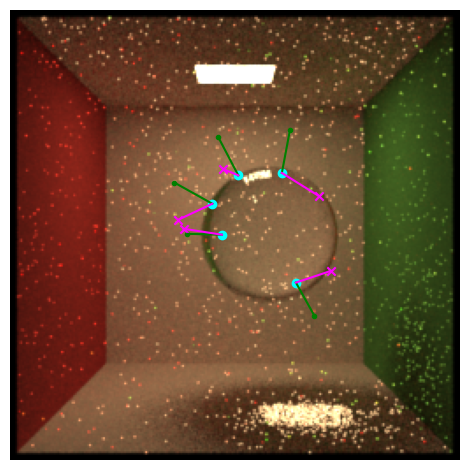

In [7]:
# helper functions for visualization
def world_to_ndc(scene, batch):
    """Transforms 3D world coordinates into normalized device coordinates (NDC) using the perspective transformation matrix.

    Args:
        scene (mi.Scene): Mitsuba 3 scene containing the camera information.
        batch (array_like): Array of 3D world coordinates.

    Returns:
        mi.Point3f: Array of 3D points in NDC.
    """
    sensor = mi.traverse(scene.sensors()[0])
    trafo = mi.Transform4f.perspective(fov=sensor['x_fov'], near=sensor['near_clip'], far=sensor['far_clip'])
    pts = trafo @ sensor['to_world'].inverse() @ mi.Point3f(np.array(batch))
    return pts

def ndc_to_pixel(pts, h, w):
    """Converts points in NDC to pixel coordinates.

    Args:
        pts (mi.Point2f): Points in NDC.
        h (float): Height of the image in pixels.
        w (float): Width of the image in pixels.

    Returns:
        mi.Point2f: Pixel coordinates of the given points.
    """
    hh, hw = h/2, w/2
    return mi.Point2f(dr.fma(pts.x, -hw, hw), dr.fma(pts.y, -hw, hh))  # not typo

def draw_multi_segments(starts, ends, color):
    """Draws multiple line segments on a plot.

    Args:
        starts (mi.Point2f): Starting points of the line segments.
        ends (mi.Point2f): Ending points of the line segments.
        color (str): Color of the line segments.
    """
    a = np.c_[starts.x, starts.y]
    b = np.c_[ends.x, ends.y]
    plt.plot(*np.c_[a, b, a*np.nan].reshape(-1, 2).T, color)

def pix_coord(scene, batch, h, w):
    """Calculates the pixel coordinates of the given 3D world coordinates.

    Args:
        scene (mi.Scene): Mitsuba 3 scene containing the camera information.
        batch (array_like): Array of 3D world coordinates.
        h (float): Height of the image in pixels.
        w (float): Width of the image in pixels.

    Returns:
        mi.Point2f: Pixel coordinates of the given 3D world coordinates.
    """
    return ndc_to_pixel(world_to_ndc(scene, batch), h, w)

def draw_si(si, ax, original_image, marker=".", color="red"):
    """Draws the surface interaction on a plot.

    Args:
        si (mi.SurfaceInteraction): Surface interaction to be drawn.
        ax (matplotlib.axes.Axes): The axes object to plot the surface interaction on.
        original_image (np.ndarray): The original image to plot on the axes.
        marker (str): Marker style for the plot.
        color (str): Color for the plot.
    """
    h, w = original_image.shape[0], original_image.shape[1] 
    x_pix = pix_coord(scene, si.p, h, w)
    wi_pix = pix_coord(scene, dr.fma(si.to_world(si.wi), 0.25, si.p), h, w)
    n_pix = pix_coord(scene, dr.fma(si.n, 0.25, si.p), h, w)

    # draw directions
    draw_multi_segments(x_pix, n_pix, 'green')
    draw_multi_segments(x_pix, wi_pix, 'magenta')

    ax.scatter(x_pix.x, x_pix.y, marker=marker, color=color)
    plt.scatter(n_pix.x, n_pix.y, marker='.', color='green')
    plt.scatter(wi_pix.x, wi_pix.y, marker='x', color='magenta')
    ax.imshow(np.clip(original_image ** (1.0 / 2.2), 0, 1))

def draw_moving_arrow(si, h, w, si_prev, ax):
    """Draws a moving arrow on a plot to represent the surface interaction movement.

    Args:
        si (mi.SurfaceInteraction): Surface interaction to be drawn.
        h (float): Height of the image in pixels.
        w (float): Width of the image in pixels.
        si_prev (mi.SurfaceInteraction): Previous surface interaction to connect to the current one.
        ax (matplotlib.axes.Axes): The axes object to plot the moving arrow on.
    """
    x_pix = pix_coord(scene, si.p, h, w)
    x_prev_pix = pix_coord(scene, si_prev.p, h, w)
    draw_multi_segments(x_prev_pix, x_pix, 'green')

# sample only on the second shape, i.e., the glass ball
tmp_area = [0] * len(m_area)
tmp_area[1] = 1
tmp_shape_sampler = mi.DiscreteDistribution(tmp_area)

l_sampler = l_sampler.clone()
l_sampler.seed(seed, 5)  # sample five points

si = sample_si(
    scene, tmp_shape_sampler, 
    l_sampler.next_1d(), l_sampler.next_2d(), l_sampler.next_2d()
)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
draw_si(si, ax, original_image, marker="o", color="cyan")

Alright, surface sampling seems to be well implemented now.
One thing to note is that in this implementation, we did not consider whether light can actually be reflected toward the direction of the outgoing direction. For example, light can never enter the inside of a box. Therefore, when we sample a position on a box surface, we do not need to sample the direction towards the inside of the box. We always need to sample the direction towards the outside of the box to enable efficient network training. 

In this tutorial, it is assumed that if only one side of a surface can be illuminated, that side is defined as the front side and the opposite side is the backside with normal vectors defined accordingly. It is also assumed that onesided BSDFs are assigned to such surfaces, while twosided BSDFs are assigned to surfaces that can be illuminated from both sides. These assumptions hold true for the Cornell box scene provided by default in Mitsuba 3. This distinction is important because most 3D scenes available for Mitsuba 3 use twosided BSDFs excessively, even for surfaces that are not illuminated. This can hinder learning. 

Of course, implementing a procedure that automatically identifies which surface is illuminated would be a good future direction.

### Network Instantiation
The network is structured as follows: to speed up training, a hash encoder proposed by InstantNGP is used to encode the position vector, rather than the multi-resolution feature grid originally proposed in Neural Radiosity. In addition, thanks to the hash encoder, the number of hidden layers in the network can be reduced from 6 to 3. Finally, the width (number of neurons) of each layer can also be reduced from 512 to 256. To further accelerate the process, the use of mixed precision is recommended (e.g., use [Lightning](https://lightning.ai/docs/pytorch/stable/common/trainer.html#precision) library). In my experiments, the network computation speed increased several times while there was no significant decrease in quality.

You might be interested in how to retrieve the outgoing direction, normal vector, and albedo in world coordinate system from the `SurfaceInteraction3f` object.
Additionally, in a standard backward path tracer, `wi` refers to the direction at which the camera ray enters the scene. However, since we are considering the direction of the light outgoing from the surface interaction, we will use the term "outgoing" here. Don't be confused.

Finally, `field` represents the neural network model.

The method `get_camera_first_bounce` and a few lines of code below it are for the purpose of verifying whether NRField is well implemented.

In [8]:
from tinycudann import Encoding as NGPEncoding

class NRField(torch.nn.Module):
    def __init__(self, bb_min, bb_max):
        """Initialize an instance of NRField.

        Args:
            bb_min (mi.ScalarBoundingBox3f): minimum point of the bounding box
            bb_max (mi.ScalarBoundingBox3f): maximum point of the bounding box
        """
        super().__init__()
        self.bb_min = bb_min
        self.bb_max = bb_max

        # positional encoding from InstantNGP [Müller et al. 2022]
        enc_config = {
		    "otype": "HashGrid",
            "base_resolution": 16,
            "n_levels": 8,
            "n_features_per_level": 4,
            "log2_hashmap_size": 22
        }
        self.pos_enc = NGPEncoding(3, enc_config)

        # network
        in_features = 3 * 4 + self.pos_enc.n_output_dims
        n_neurons = 256
        layers = [  # two hidden layers
            torch.nn.Linear(in_features, n_neurons), 
            torch.nn.ReLU(),
            torch.nn.Linear(n_neurons, n_neurons), 
            torch.nn.ReLU(),
            torch.nn.Linear(n_neurons, n_neurons), 
            torch.nn.ReLU(),
            torch.nn.Linear(n_neurons, n_neurons), 
            torch.nn.ReLU(),
            torch.nn.Linear(n_neurons, 3)
        ]
        self.rgb_net = torch.nn.Sequential(*layers)
    
    def forward(self, si):
        """Forward pass for NRField.

        Args:
            si (mitsuba.SurfaceInteraction3f): surface interaction

        Returns:
            torch.Tensor
        """
        # basic inputs
        with dr.suspend_grad():
            x = ((si.p - self.bb_min) / (self.bb_max - self.bb_min)).torch()
            wi = si.to_world(si.wi).torch()  # world coordinate
            n = si.sh_frame.n.torch()
            
            # get the direction-independent albedo (NOTE) Trick!!!
            si_view = mi.SurfaceInteraction3f(si)
            si_view.wi = mi.Point3f([0.353553, 0.353553, 0.866025])
            f_d = si_view.bsdf().eval_diffuse_reflectance(si_view).torch()

        # input encoding
        z_x = self.pos_enc(x)

        # network processing
        inp = torch.concat([x, wi, n, f_d, z_x], dim=1)
        out = self.rgb_net(inp)
        out = torch.abs(out)
        return out.to(torch.float32)

def get_camera_first_bounce(scene):
    cam_origin = mi.Point3f(0, 1, 3)
    cam_dir = dr.normalize(mi.Vector3f(0, -0.5, -1))
    cam_width = 2.0
    cam_height = 2.0
    image_res = [256, 256]

    x, y = dr.meshgrid(
        dr.linspace(mi.Float, -cam_width / 2, cam_width / 2, image_res[0]),
        dr.linspace(mi.Float, -cam_height / 2, cam_height / 2, image_res[1]),
    )
    ray_origin_local = mi.Vector3f(x, y, 0)
    ray_origin = mi.Frame3f(cam_dir).to_world(ray_origin_local) + cam_origin
    ray = mi.Ray3f(o=ray_origin, d=cam_dir)
    si = scene.ray_intersect(ray)

    return si, image_res

field = NRField(scene.bbox().min, scene.bbox().max).cuda()
si, image_res = get_camera_first_bounce(scene)
field(si)

tensor([[0.0820, 0.0276, 0.0836],
        [0.0820, 0.0276, 0.0836],
        [0.0820, 0.0276, 0.0836],
        ...,
        [0.0806, 0.0252, 0.0820],
        [0.0806, 0.0252, 0.0820],
        [0.0806, 0.0252, 0.0820]], device='cuda:0', grad_fn=<AbsBackward0>)

If you are genuinely curious about the implementation of the multi-resolution feature grid, please refer to the following class. By the way, the implementation of the TorchDenseGrid below is a "simplified" version of the original multi-resolution feature grid. In the original Neural Radiosity paper, the feature grid is implemented sparsely, resulting in memory growth that is quadratic rather than cubic. To implement this, please refer to the supplementary material (section D) of the Neural Radiosity paper.

In [9]:
from math import ceil

class TorchDenseGrid(torch.nn.Module):
    def __init__(self, config):
        super().__init__()

        self.n_output_dims = 16
        base_resolution = config["base_resolution"]
        n_levels = config["n_levels"]
        per_level_scale = config["per_level_scale"]
        randomize_grid = config["randomize_grid"]

        assert base_resolution >= 2, base_resolution

        dense_grid = lambda res: torch.nn.Parameter(
            torch.rand((res, res, res, self.n_output_dims))
            if randomize_grid
            else 0.5 * torch.ones((res, res, res, self.n_output_dims))
        )

        self.grids = torch.nn.ParameterList(
            [
                dense_grid(ceil(base_resolution * per_level_scale**level))
                for level in range(n_levels)
            ]
        )

    def forward(self, x):
        stacked_features = torch.stack([self.eval_grid(grid, x) for grid in self.grids])
        out = torch.mean(stacked_features, dim=0)
        return out

    def eval_grid(self, grid: torch.nn.Parameter, p: torch.Tensor):
        """Evaluates the feature at `p` given multi-resolution grids.

        Args:
            grid (torch.nn.Parameter): the 3D feature grid consists of `torch.nn.Parameter` of shape (R, R, R, F)
            p (torch.Tensor): the [0,1]-normalized positional tensor of shape (B, 3)

        Returns:
            out (torch.Tensor): tensor of shape (B, F)
        """
        assert len(grid.shape) == 4
        assert grid.shape[0] == grid.shape[1] == grid.shape[2]
        assert len(p.shape) == 2 and p.shape[1] == 3

        n_feats = grid.shape[-1]
        p = torch.clip(p, min=0, max=1) * 2 - 1  # ignore some outliers
        p = p.reshape(1, 1, 1, -1, 3).flip((-1,))  # (1, 1, 1, B, 3)
        grid = torch.permute(grid[None, ...], (0, 4, 1, 2, 3))  # (1, F, R, R, R)
        out = torch.nn.functional.grid_sample(
            grid, p, align_corners=True
        )  # (1, F, 1, 1, B)
        out = out.reshape(n_feats, -1).T  # (B, F)
        return out

### Left Hand Side of Rendering Equation
Let's now evaluate the left-hand side and right-hand side of the rendering equation using a neural network `model`. First, we implement the left-hand side. The left-hand side essentially only requires computing the neural network at a given position and direction when `si` is given as input. However, we defined a mask called `null_face` to represent back-faced surfaces as black. The `render_lhs` function outputs several values, but `Le`, `out`, and `mask` are the only ones used to decompose `L`, since only `out` is connected to the computational graph of the neural network, and the others are considered as constants from the neural network's perspective. `L` is used for visualization purposes.

In [10]:
def render_lhs(scene, model, si):
    """
    Renders the left-hand side of the rendering equation by calculating the emitter's radiance and
    the neural network output at the given surface interaction (si) position and direction (bsdf).
    
    Args:
        scene (mi.Scene): A Mitsuba scene object.
        model (torch.nn.Module): A neural network model that takes si and bsdf as input and returns
            a predicted radiance value.
        si (mi.SurfaceInteraction3f): A Mitsuba surface interaction object.
        
    Returns:
        tuple: A tuple containing four values:
            - L (mi.Spectrum): The total outgoing radiance value.
            - Le (mi.Spectrum): The emitter's radiance.
            - out (torch.Tensor): The neural network's predicted radiance value.
            - mask (torch.Tensor): A boolean tensor indicating which surface interactions are valid.
    """
    with dr.suspend_grad():
        Le = si.emitter(scene).eval(si)

        # discard the null bsdf backside
        null_face = ~mi.has_flag(si.bsdf().flags(), mi.BSDFFlags.BackSide) & (
            si.wi.z < 0
        )
        mask = si.is_valid() & ~null_face

        out = model(si)
        L = Le + dr.select(mask, mi.Spectrum(out), 0)

    return L, Le, out, mask

We will now implement a Mitsuba integrator called `LHSIntegrator` to verify if our `render_lhs` function is well-implemented. In Neural Radiosity, to render dirac surfaces such as perfect metals, we do not compute the neural network on the surface itself, but instead iterate through ray tracing until we find the first non-dirac surface, and then query the neural network at that surface.

In [13]:
def first_non_specular_or_null_si(scene, si, sampler):
    """Find the first non-specular or null surface interaction.

    Args:
        scene (mi.Scene): Scene object.
        si (mi.SurfaceInteraction3f): Surface interaction.
        sampler (mi.Sampler): Sampler object.

    Returns:
        tuple: A tuple containing four values:
            - si (mi.SurfaceInteraction3f): First non-specular or null surface interaction.
            - β (mi.Spectrum): The product of the weights of all previous BSDFs.
            - null_face (bool): A boolean mask indicating whether the surface is a null face or not.
    """
    # Instead of `bsdf.flags()`, based on `bsdf_sample.sampled_type`.
    with dr.suspend_grad():
        bsdf_ctx = mi.BSDFContext()

        depth = mi.UInt32(0)
        β = mi.Spectrum(1)
        bsdf = si.bsdf()

        null_face = ~mi.has_flag(si.bsdf().flags(), mi.BSDFFlags.BackSide) & (
            si.wi.z < 0
        )
        active = si.is_valid() & ~null_face  # non-null surface
        active &= ~mi.has_flag(si.bsdf().flags(), mi.BSDFFlags.Smooth)  # Delta surface

        loop = mi.Loop(
            name="first_non_specular_or_null_si",
            state=lambda: (sampler, depth, β, active, null_face, si, bsdf),
        )
        max_depth = 6
        loop.set_max_iterations(max_depth)

        while loop(active):
            # loop invariant: si is located at non-null and Delta surface
            # if si is located at null or Smooth surface, end loop
            bsdf_sample, bsdf_weight = bsdf.sample(
                bsdf_ctx, si, sampler.next_1d(), sampler.next_2d(), active
            )
            ray = si.spawn_ray(si.to_world(bsdf_sample.wo))
            si = scene.ray_intersect(
                ray, ray_flags=mi.RayFlags.All, coherent=dr.eq(depth, 0)
            )
            bsdf = si.bsdf(ray)

            β *= bsdf_weight
            depth[si.is_valid()] += 1

            null_face &= ~mi.has_flag(bsdf.flags(), mi.BSDFFlags.BackSide) & (
                si.wi.z < 0
            )
            active &= si.is_valid() & ~null_face & (depth < max_depth)
            active &= ~mi.has_flag(bsdf.flags(), mi.BSDFFlags.Smooth)

    # return si at the first non-specular bounce or null face
    return si, β, null_face

The following code implements the `LHSIntegrator` using the `first_non_specular_or_null_si` and `render_lhs` functions. Once this integrator is implemented, we can render the left-hand side of the rendering equation by specifying `lhs_integrator` as the integrator in the `mi.render` function. Of course, since the network has not yet learned anything, the resulting image will be almost meaningless. Nevertheless, we can observe that the reflections on the metal box are well represented.

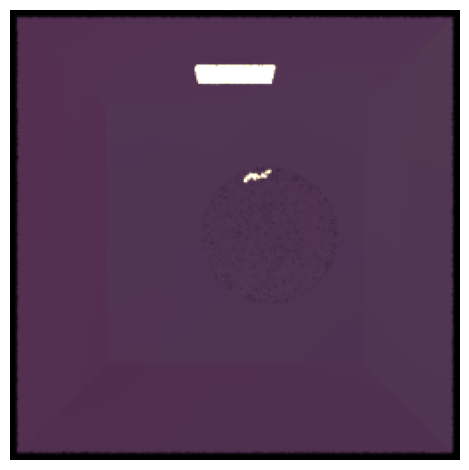

In [14]:
class LHSIntegrator(ADIntegrator):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def sample(
        self,
        mode,
        scene,
        sampler,
        ray,
        depth,
        reparam,
        active,
        **kwargs,
    ):

        self.model.eval()
        with torch.no_grad():
            w, h = list(scene.sensors()[0].film().size())
            L = mi.Spectrum(0)

            ray = mi.Ray3f(dr.detach(ray))
            si = scene.ray_intersect(
                ray, ray_flags=mi.RayFlags.All, coherent=dr.eq(depth, 0)
            )

            # update si and bsdf with the first non-specular ones
            si, β, _ = first_non_specular_or_null_si(scene, si, sampler)
            L, _, _, _ = render_lhs(scene, self.model, si)

        self.model.train()
        torch.cuda.empty_cache()
        return β * L, si.is_valid(), None

lhs_integrator = LHSIntegrator(field)
lhs_image = mi.render(scene, spp=4, integrator=lhs_integrator)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
ax.imshow(np.clip(lhs_image ** (1.0 / 2.2), 0, 1))

### Right Hand Side of Rendering Equation

Now let's calculate the right-hand side of the rendering equation using a neural network `model`. The code has become more complex than `render_lhs`, but don't be afraid. We just need to do next event estimation and BSDF sampling through multiple importance sampling. Also, since the ray obtained through BSDF sampling can intersect with dirac surfaces, another `first_non_specular_or_null_si` operation is required. We need to consider the attenuation through multiple reflections, so we also output an additional variable `w_nr` compared to `render_lhs`.

In [15]:
def render_rhs(scene, model, si, sampler):
    with dr.suspend_grad():
        bsdf_ctx = mi.BSDFContext()

        depth = mi.UInt32(0)
        L = mi.Spectrum(0)
        β = mi.Spectrum(1)
        η = mi.Float(1)
        prev_si = dr.zeros(mi.SurfaceInteraction3f)
        prev_bsdf_pdf = mi.Float(1.0)
        prev_bsdf_delta = mi.Bool(True)

        bsdf = si.bsdf()
        Le = β * si.emitter(scene).eval(si)

        # emitter sampling
        active_next = si.is_valid()
        active_em = active_next & mi.has_flag(bsdf.flags(), mi.BSDFFlags.Smooth)

        ds, em_weight = scene.sample_emitter_direction(
            si, sampler.next_2d(), True, active_em
        )
        active_em &= dr.neq(ds.pdf, 0.0)

        wo = si.to_local(ds.d)
        bsdf_value_em, bsdf_pdf_em = bsdf.eval_pdf(bsdf_ctx, si, wo, active_em)
        mis_em = dr.select(ds.delta, 1, mis_weight(ds.pdf, bsdf_pdf_em))
        Lr_dir = β * mis_em * bsdf_value_em * em_weight

        # bsdf sampling
        bsdf_sample, bsdf_weight = bsdf.sample(
            bsdf_ctx, si, sampler.next_1d(), sampler.next_2d(), active_next
        )

        # update
        L = L + Le + Lr_dir
        ray = si.spawn_ray(si.to_world(bsdf_sample.wo))
        η *= bsdf_sample.eta
        β *= bsdf_weight

        prev_si = dr.detach(si, True)
        prev_bsdf_pdf = bsdf_sample.pdf
        prev_bsdf_delta = mi.has_flag(bsdf_sample.sampled_type, mi.BSDFFlags.Delta)

        si = scene.ray_intersect(ray, ray_flags=mi.RayFlags.All, coherent=True)

        ds = mi.DirectionSample3f(scene, si=si, ref=prev_si)

        mis = mis_weight(
            prev_bsdf_pdf,
            scene.pdf_emitter_direction(prev_si, ds, ~prev_bsdf_delta),
        )
        
        si, β2, null_face = first_non_specular_or_null_si(scene, si, sampler)
        β *= β2

        L += β * mis * si.emitter(scene).eval(si)

        out = model(si)
        active_nr = (
            si.is_valid()
            & ~null_face
            & dr.eq(si.emitter(scene).eval(si), mi.Spectrum(0))
        )

        Le = L
        w_nr = β * mis
        L = Le + dr.select(active_nr, w_nr * mi.Spectrum(out), 0)

    return L, Le, out, w_nr, active_nr

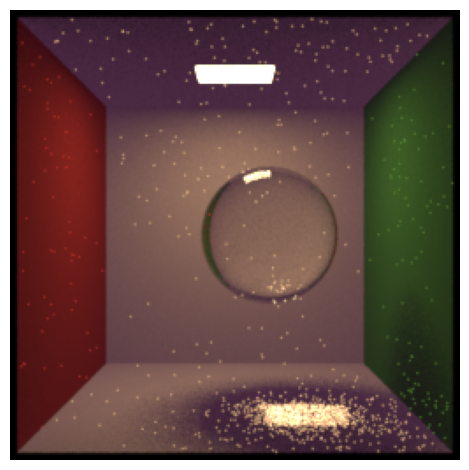

In [16]:
class RHSIntegrator(ADIntegrator):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def sample(
        self,
        mode,
        scene,
        sampler,
        ray,
        depth,
        reparam,
        active,
        **kwargs,
    ):
        self.model.eval()
        with torch.no_grad():
            w, h = list(scene.sensors()[0].film().size())
            L = mi.Spectrum(0)

            ray = mi.Ray3f(dr.detach(ray))
            si = scene.ray_intersect(
                ray, ray_flags=mi.RayFlags.All, coherent=dr.eq(depth, 0)
            )

            # update si and bsdf with the first non-specular ones
            si, β, _ = first_non_specular_or_null_si(scene, si, sampler)
            L, _, _, _, _ = render_rhs(scene, self.model, si, sampler)

        self.model.train()
        torch.cuda.empty_cache()
        return β * L, si.is_valid(), None

rhs_integrator = RHSIntegrator(field)
rhs_image = mi.render(scene, spp=M, integrator=rhs_integrator)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
ax.imshow(np.clip(rhs_image ** (1.0 / 2.2), 0, 1))

### Let's Train the Model!
Let's put it all together.
`_l_sampler` and `_r_sampler` are copies of `l_sampler` and `r_sampler`, respectively. `l_sampler` and `r_sampler` are samplers used during rendering. `_l_sampler` and `_r_sampler` are set to have new seed values at each training step. It is important to clone the samplers and assign new seeds for each step. If the same sampler is used for each iteration without cloning, calling the `next_1/2d()` function will create a lengthy computation graph proportional to the total number of steps, which can have a negative impact on performance due to the characteristics of the Dr.Jit library.

A random surface interaction (`si`) and BSDF (`bsdf`) are generated using the `sample_si` function. `si_lhs` and `bsdf_lhs` are used for computing the left-hand side in the `render_lhs` function. `si_rhs` and `bsdf_rhs` are used for computing the right-hand side in the `render_rhs` function. Take a look at how the `arange`, `repeat`, and `gather` functions are used to copy `si_lhs` to create `si_rhs` in the following code. This copying operation is necessary to extract M/2 incident directions in parallel from a single `si`.

`Le_lhs`, `out_lhs`, and `mask_lhs` are used in `render_lhs` for computing the left-hand side. Similarly, `Le_rhs`, `out_rhs`, `mask_rhs`, and `weight_rhs` are used in `render_rhs` for computing the right-hand side. The loss between the left-hand side and right-hand side is computed and used for optimization. `loss` is the mean squared error (MSE) between the left-hand side and right-hand side. At each optimization step, the loss value is added to the `train_losses` list. While the original loss function of Neural Radiosity includes normalization, we observed that it creates a bias that makes the final rendering results darker in our experiments.

In [17]:
optimizer = torch.optim.Adam(field.parameters(), lr=lr)
train_losses = []
tqdm_iterator = tqdm(range(total_steps))

field.train()
for step in tqdm_iterator:
    optimizer.zero_grad()

    # detach the computation graph of samplers to avoid lengthy graph of dr.jit
    _l_sampler = l_sampler.clone()
    _l_sampler.seed(step, batch_size)
    _r_sampler = r_sampler.clone()
    _r_sampler.seed(step, batch_size * M // 2)

    si_lhs = sample_si(scene, shape_sampler, _l_sampler.next_1d(), _l_sampler.next_2d(), _l_sampler.next_2d())

    # copy `si_lhs` M//2 times for RHS evaluation
    indices = dr.arange(mi.UInt, 0, batch_size)
    indices = dr.repeat(indices, M // 2)
    si_rhs = dr.gather(type(si_lhs), si_lhs, indices)

    # LHS and RHS evaluation
    _, Le_lhs, out_lhs, mask_lhs = render_lhs(scene, field, si_lhs)
    _, Le_rhs, out_rhs, weight_rhs, mask_rhs = render_rhs(scene, field, si_rhs, _r_sampler)
    weight_rhs = weight_rhs.torch() * mask_rhs.torch()

    lhs = Le_lhs.torch() + out_lhs * mask_lhs.torch().reshape(-1, 1)
    rhs = Le_rhs.torch() + out_rhs * weight_rhs
    rhs = rhs.reshape(batch_size, M // 2, 3).mean(dim=1)

    norm = 1  
    # in our experiment, normalization makes rendering biased (dimmer)
    # norm = (lhs + rhs).detach()/2 + 1e-2

    loss = torch.nn.MSELoss()(lhs / norm, rhs / norm)
    loss.backward()
    optimizer.step()

    tqdm_iterator.set_description("Loss %.04f" % (loss.item()))
    train_losses.append(loss.item())
field.eval()

Loss 0.0090: 100%|██████████| 1000/1000 [01:07<00:00, 14.73it/s]


NRField(
  (pos_enc): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float16, hyperparams={'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 22, 'n_features_per_level': 4, 'n_levels': 8, 'otype': 'Grid', 'per_level_scale': 2.0, 'type': 'Hash'})
  (rgb_net): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=3, bias=True)
  )
)

The loss is converging very quickly over time. However, it does not converge to completely 0 due to the variance in RHS. The variance in RHS can be visualized below.

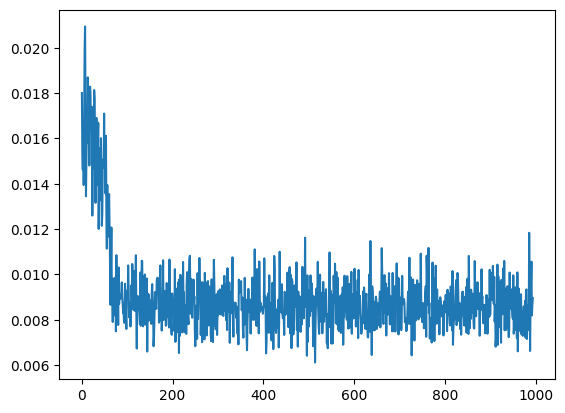

In [18]:
# plt.yscale("log")
plt.plot(train_losses[5:])

The below code shows the LHS rendering.

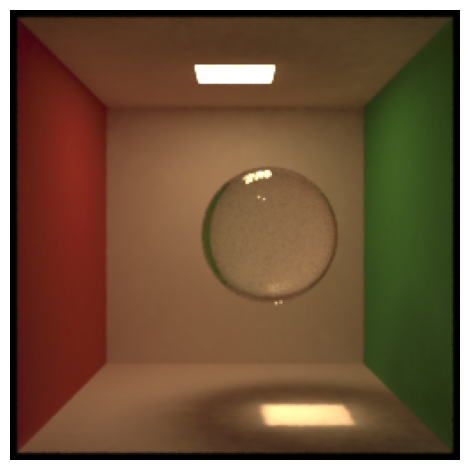

In [19]:
lhs_integrator = LHSIntegrator(field)
lhs_image = mi.render(scene, spp=16, integrator=lhs_integrator)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
ax.imshow(np.clip(lhs_image ** (1.0 / 2.2), 0, 1))

The below code shows the path tracing rendering with 1024 samples per pixel.

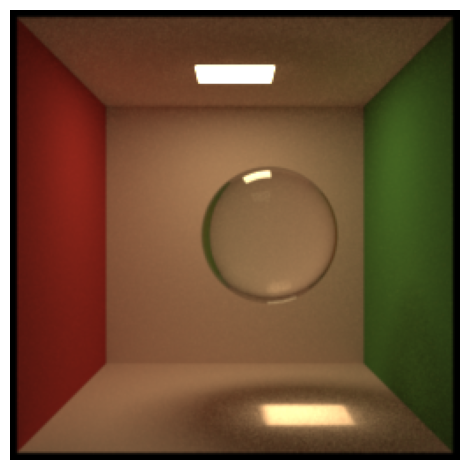

In [20]:
original_image = mi.render(scene, spp=1024*4)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
ax.imshow(np.clip(original_image ** (1.0 / 2.2), 0, 1))

The following code shows the RHS rendering, which exhibits relatively more severe variance than the LHS.

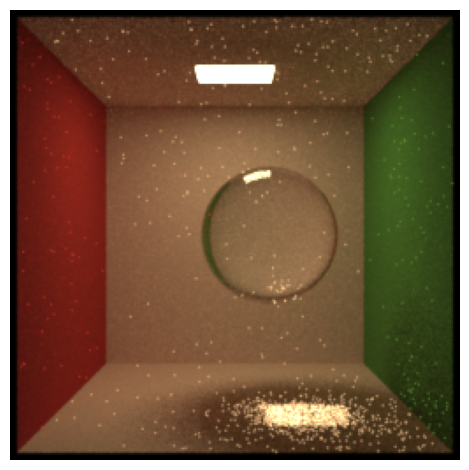

In [21]:
rhs_integrator = RHSIntegrator(field)
rhs_image = mi.render(scene, spp=M, integrator=rhs_integrator)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
ax.imshow(np.clip(rhs_image ** (1.0 / 2.2), 0, 1))

That's it for this tutorial. 

I hope that you have gained insights into which methodology is more suitable for video rendering by comparing the time required to get a clean rendering with path tracing and the time required to learn and render with Neural Radiosity under various conditions. 

Of course, I cannot guarantee that the code presented here is optimal since I am not an expert in Mitsuba 3. I always welcome any better code! It would be great if we could learn together. I hope that this tutorial has been helpful in learning Mitsuba and creating functional research code.  Furthermore, I look forward to more graphics code being written in Mitsuba 3 and publicly available starting this year. Learning Mitsuba 3 is really fun, so we hope you enjoy it too.